https://www.kaggle.com/code/vaibhavgupta05/generating-brain-mri-images-with-dc-gan-a29b19

# Setup

* Numpy and Tensorflow for Mathematical Operations
* Matplotlib and OpenCV for Image data handling and Visualization
* Keras for the Neural Networks

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH = 3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
MAIN_DIR = "/kaggle/input/dslab-data/Training/pituitary"

# Loading and Preprocessing the Images

In [4]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [5]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((1106, 128, 128), (1106,))

## Generate 20 random numbers to index images from data

In [6]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [7]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

## Normalize and Reshape the Data

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

## Plotting The Real Images

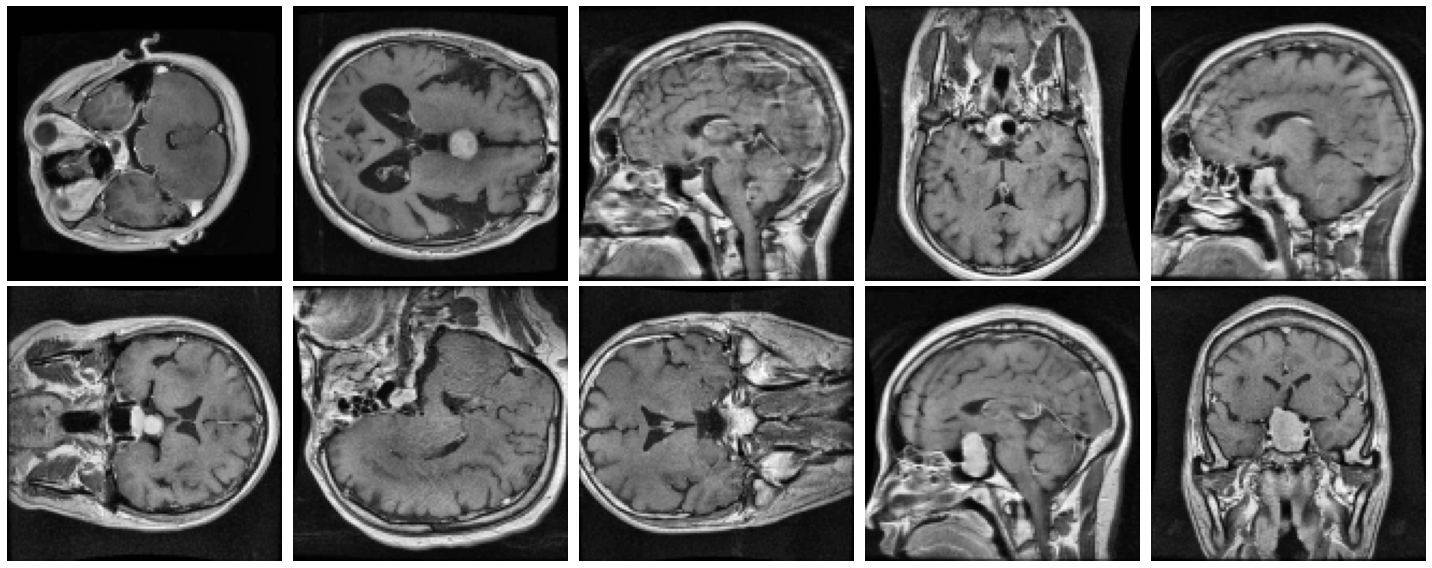

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

# Putting it together

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)   

In [13]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## The Training

100%|██████████| 3750/3750 [06:13<00:00, 10.04it/s]


EPOCH: 1 Generator Loss: 6.9984 Discriminator Loss: 0.0487


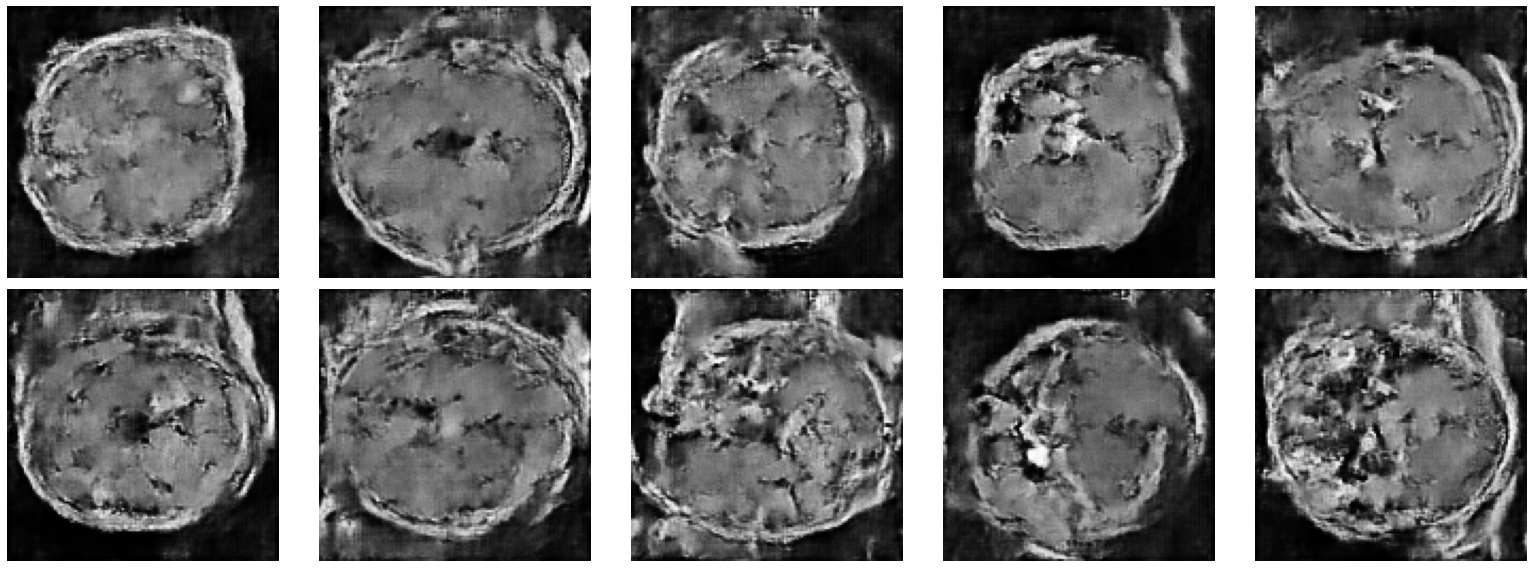

100%|██████████| 3750/3750 [05:59<00:00, 10.43it/s]


EPOCH: 2 Generator Loss: 8.6600 Discriminator Loss: 0.0235


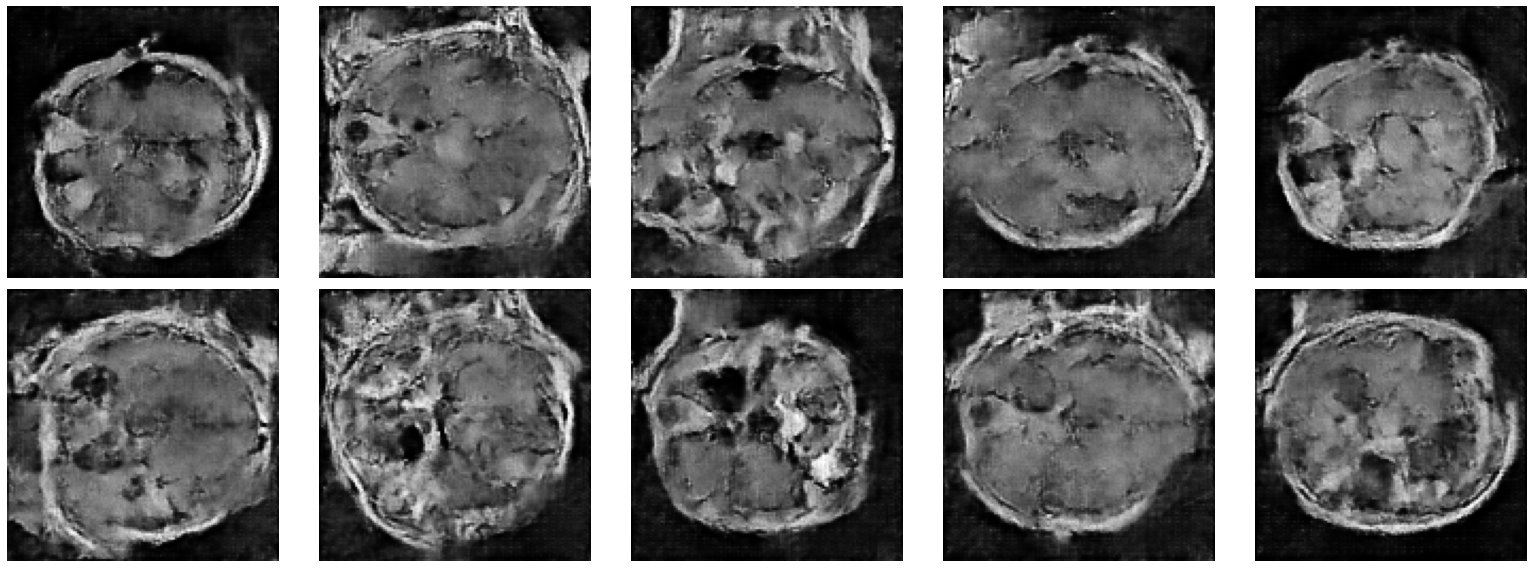

100%|██████████| 3750/3750 [05:59<00:00, 10.42it/s]


EPOCH: 3 Generator Loss: 13.2655 Discriminator Loss: 0.2599


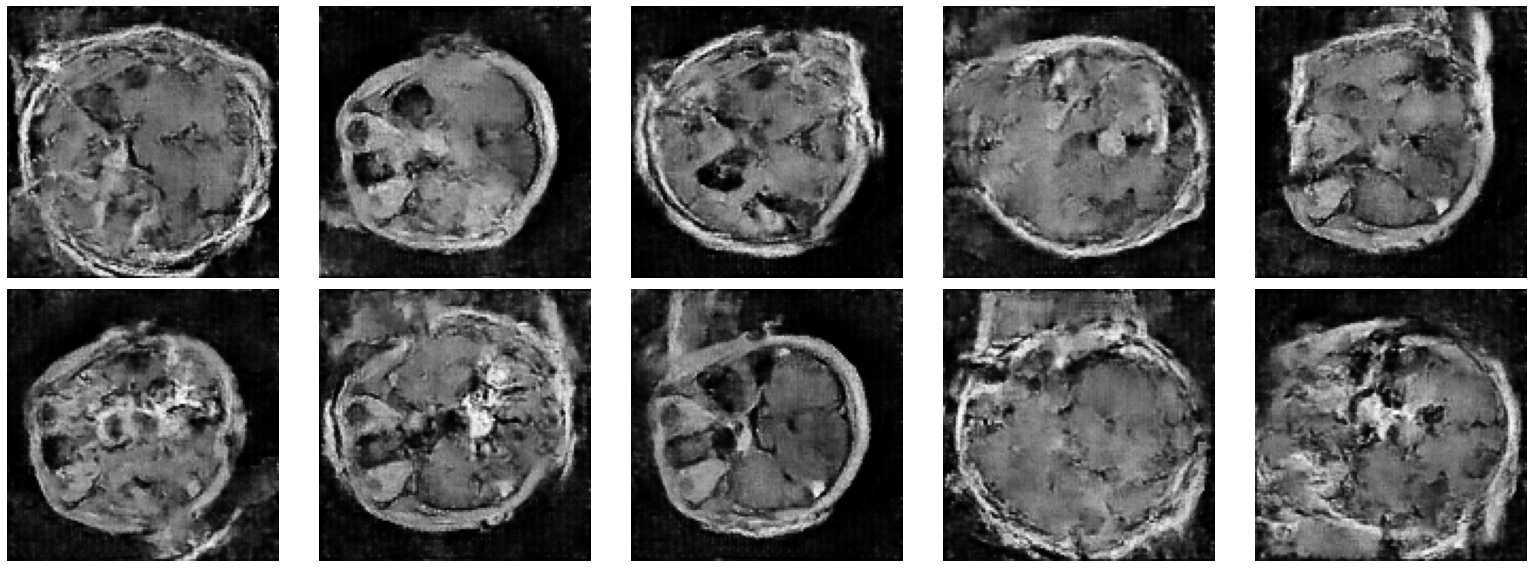

100%|██████████| 3750/3750 [06:00<00:00, 10.41it/s]


EPOCH: 4 Generator Loss: 14.2081 Discriminator Loss: 0.0138


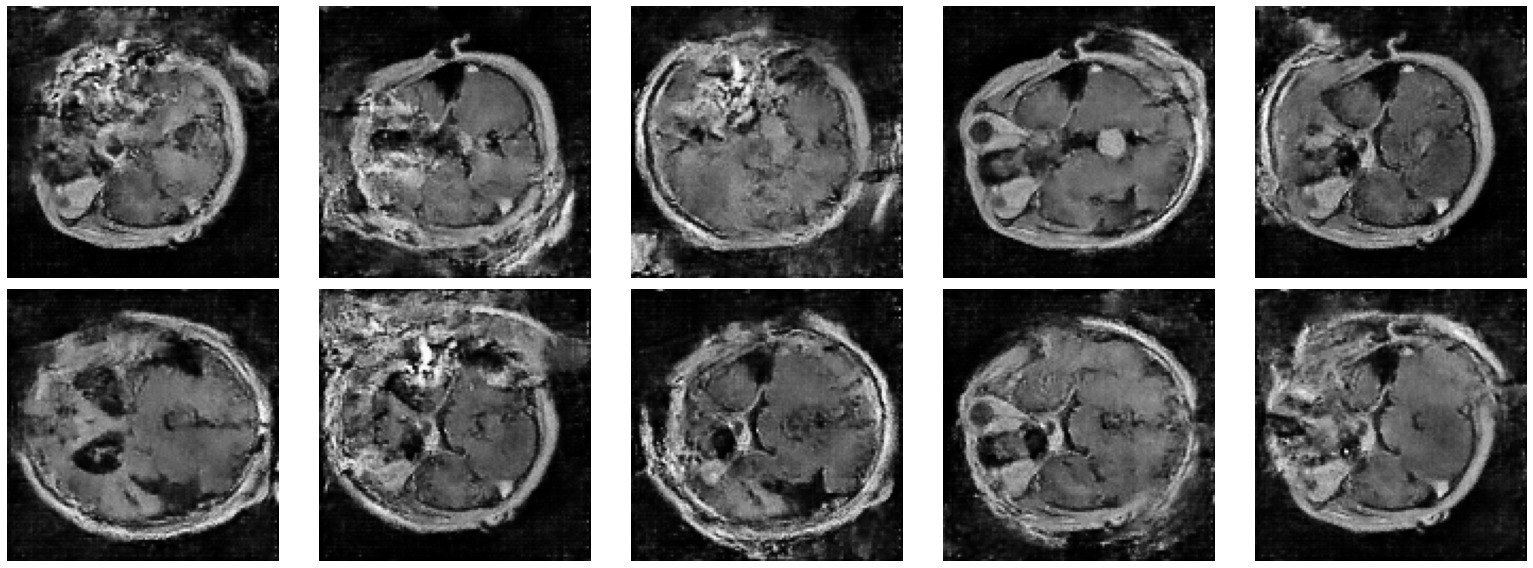

100%|██████████| 3750/3750 [06:01<00:00, 10.39it/s]


EPOCH: 5 Generator Loss: 4.4501 Discriminator Loss: 0.0071


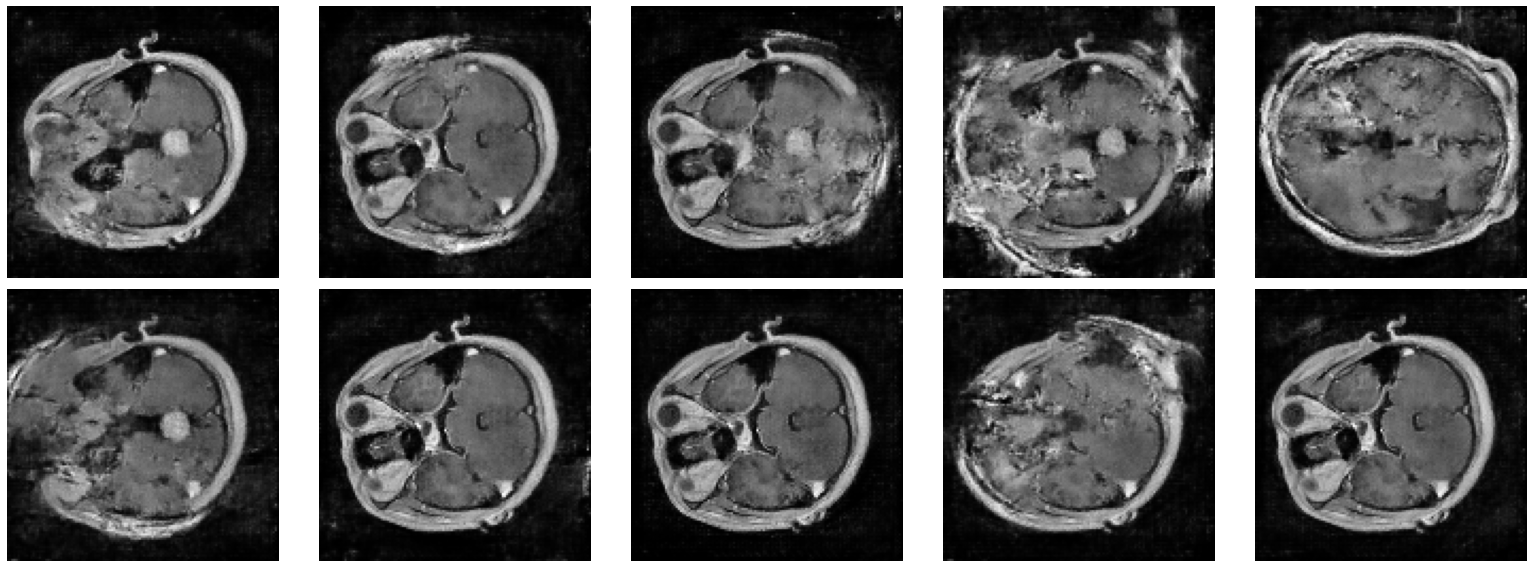

100%|██████████| 3750/3750 [06:01<00:00, 10.38it/s]


EPOCH: 6 Generator Loss: 8.9383 Discriminator Loss: 0.0014


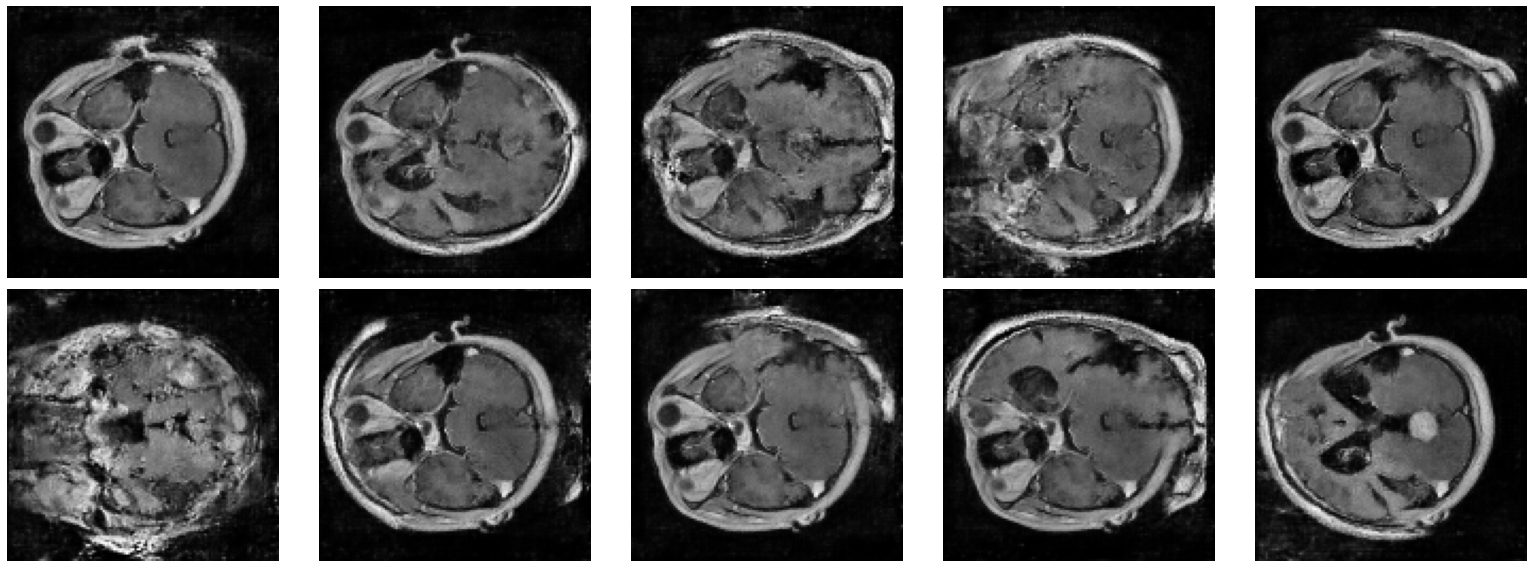

100%|██████████| 3750/3750 [06:02<00:00, 10.35it/s]


EPOCH: 7 Generator Loss: 4.0516 Discriminator Loss: 0.1257


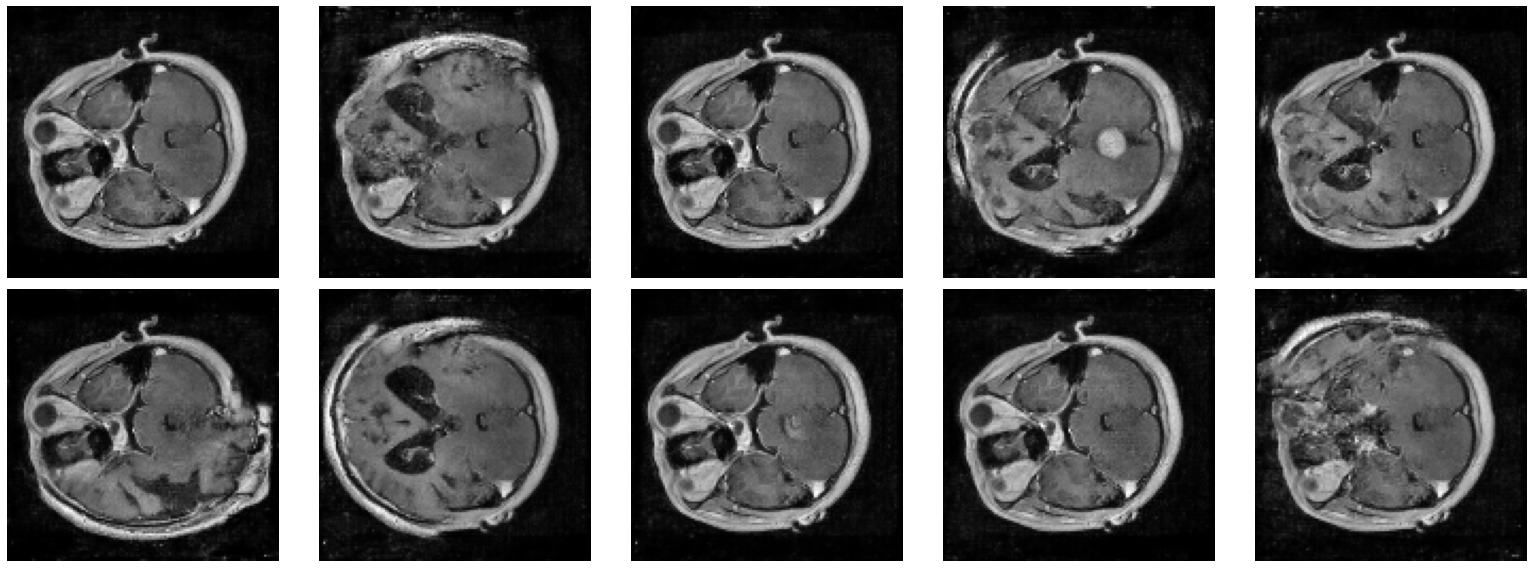

100%|██████████| 3750/3750 [06:02<00:00, 10.35it/s]


EPOCH: 8 Generator Loss: 4.3606 Discriminator Loss: 0.0904


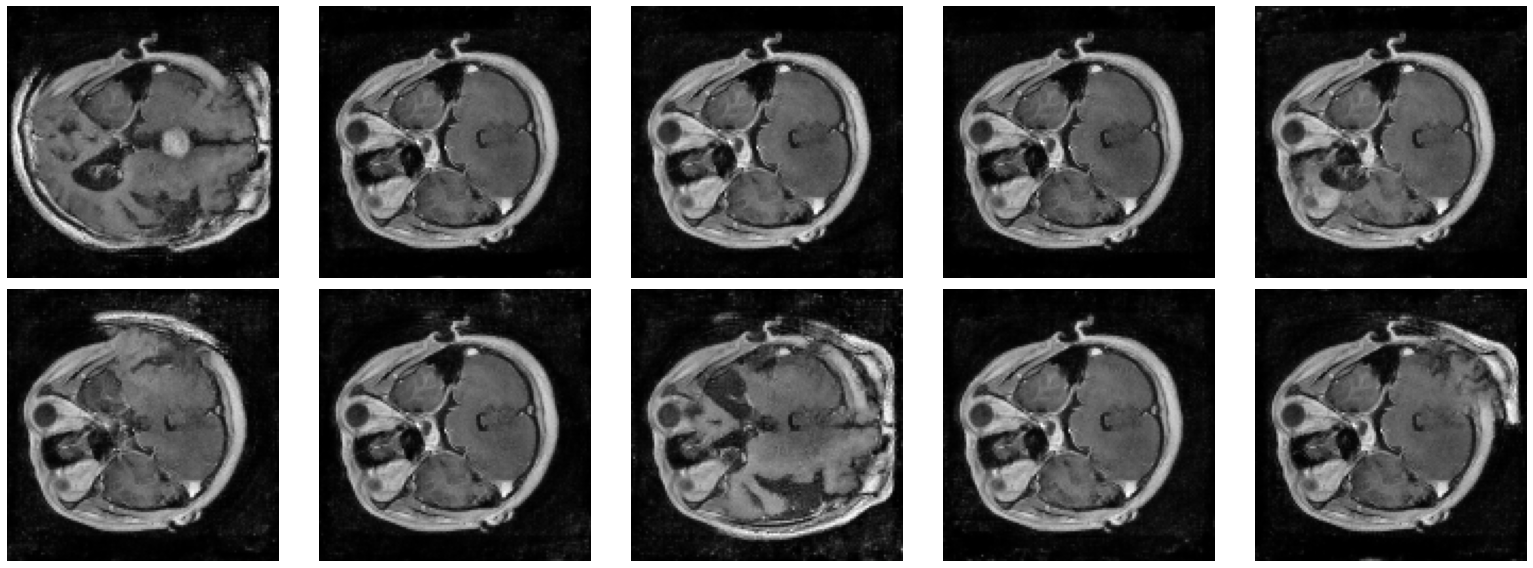

100%|██████████| 3750/3750 [06:02<00:00, 10.34it/s]


EPOCH: 9 Generator Loss: 4.0284 Discriminator Loss: 0.0472


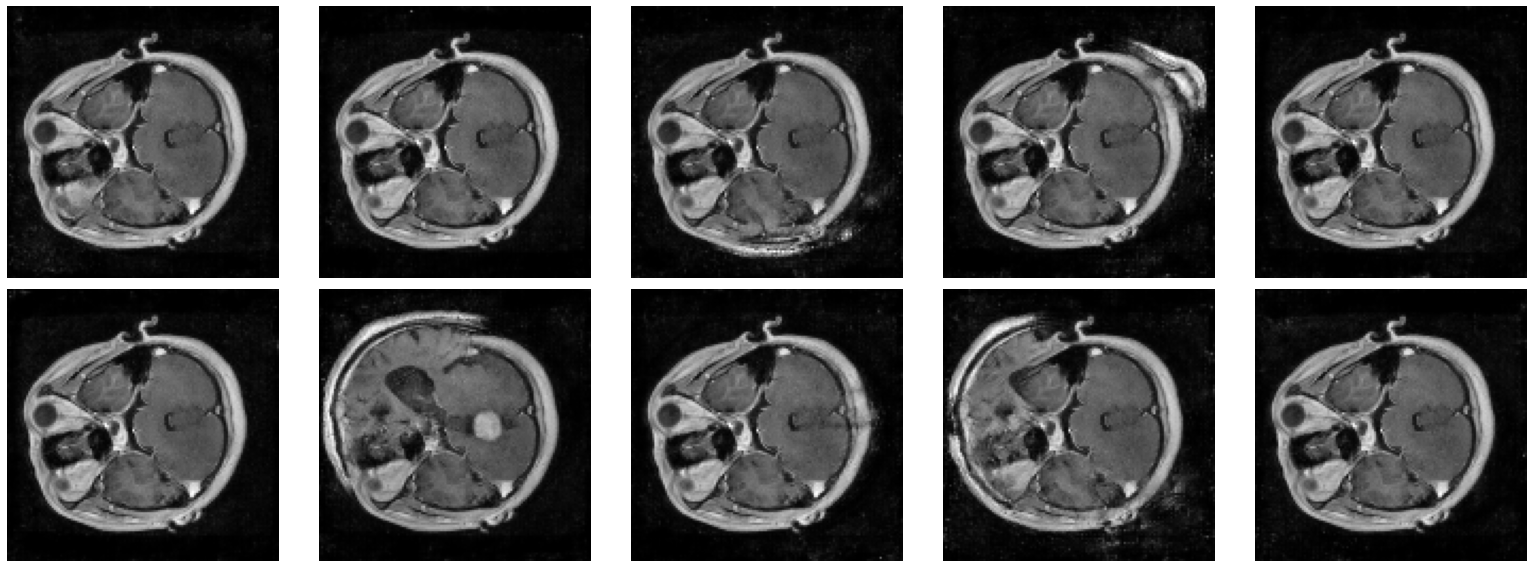

100%|██████████| 3750/3750 [06:04<00:00, 10.30it/s]


EPOCH: 10 Generator Loss: 4.5795 Discriminator Loss: 0.0121


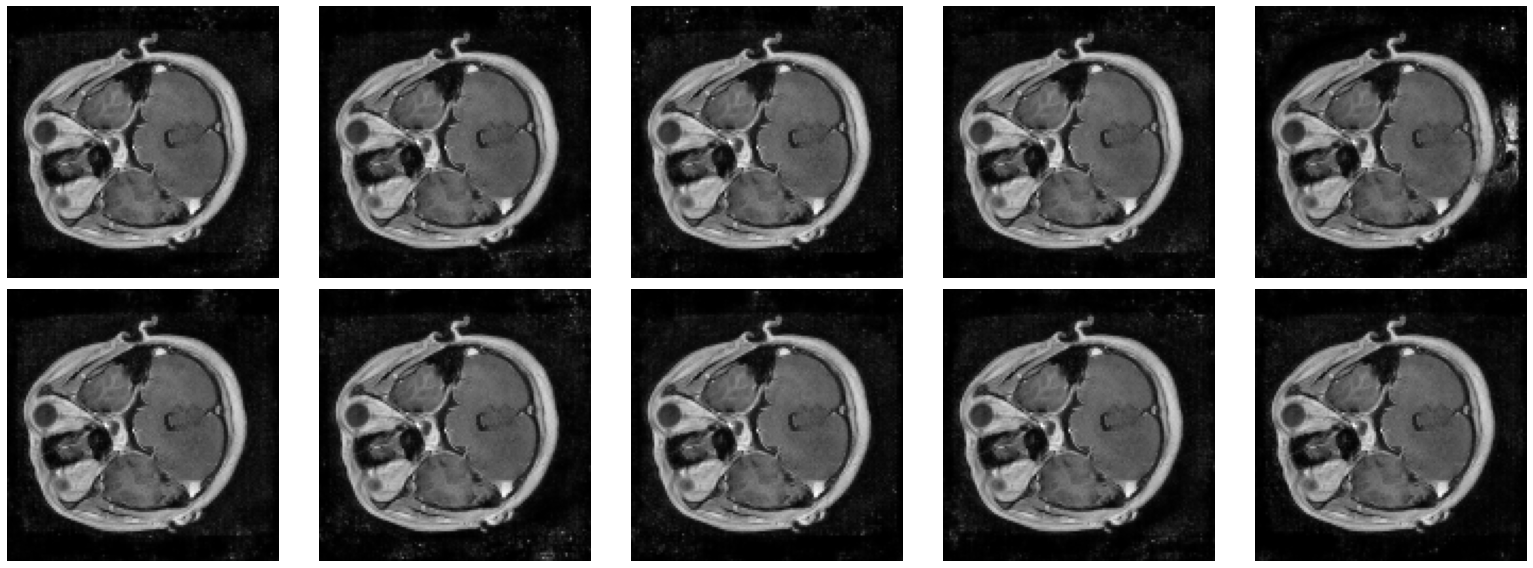

In [14]:
np.random.seed(SEED)
for epoch in range(10):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

# Let's generate some images !

In [16]:
import numpy as np
from PIL import Image
import os
import zipfile

# Ensure the kaggle/working directory exists
os.makedirs('kaggle/working', exist_ok=True)

# Constants
IMAGE_COUNT = 200
IMAGE_SIZE = (256, 256)

# Generate and save images
for i in range(IMAGE_COUNT):
    # Generate noise and image
    noise = np.random.normal(0, 1, size=(1, NOISE_DIM))
    generated_image = generator.predict(noise)

    # Rescale the image
    generated_image = (generated_image * 127.5) + 127.5
    generated_image = generated_image.astype(np.uint8)

    # Convert to grayscale and resize
    img_array = np.squeeze(generated_image[0, :, :, :])  # Remove batch dimension
    img = Image.fromarray(img_array).convert('L')
    img = img.resize(IMAGE_SIZE)

    # Save the image
    filename = f'kaggle/working/image_{i+1}.jpg'
    img.save(filename)

# Create a zip file
with zipfile.ZipFile('kaggle/working/generated_images.zip', 'w') as zipf:
    for i in range(IMAGE_COUNT):
        img_path = f'kaggle/working/image_{i+1}.jpg'
        zipf.write(img_path, arcname=os.path.basename(img_path))

print("Grayscale images are saved and zipped in 'kaggle/working/generated_images'")

Grayscale images are saved and zipped in 'kaggle/working/generated_images'


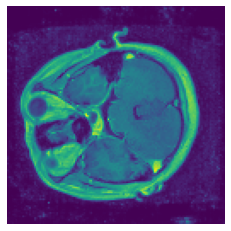

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise
noise = np.random.normal(0, 1, size=(1, NOISE_DIM))

# Generate image
generated_image = generator.predict(noise)

# Rescale the image (if needed)
generated_image = (generated_image * 127.5) + 127.5
generated_image = generated_image.astype(np.uint8)

# Visualize the image
plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()

In [ ]:
noise = np.random.normal(0, 1, size=(50, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

In [29]:
generated_images = generator.predict(noise)
generated_images.shape

(1, 128, 128, 1)

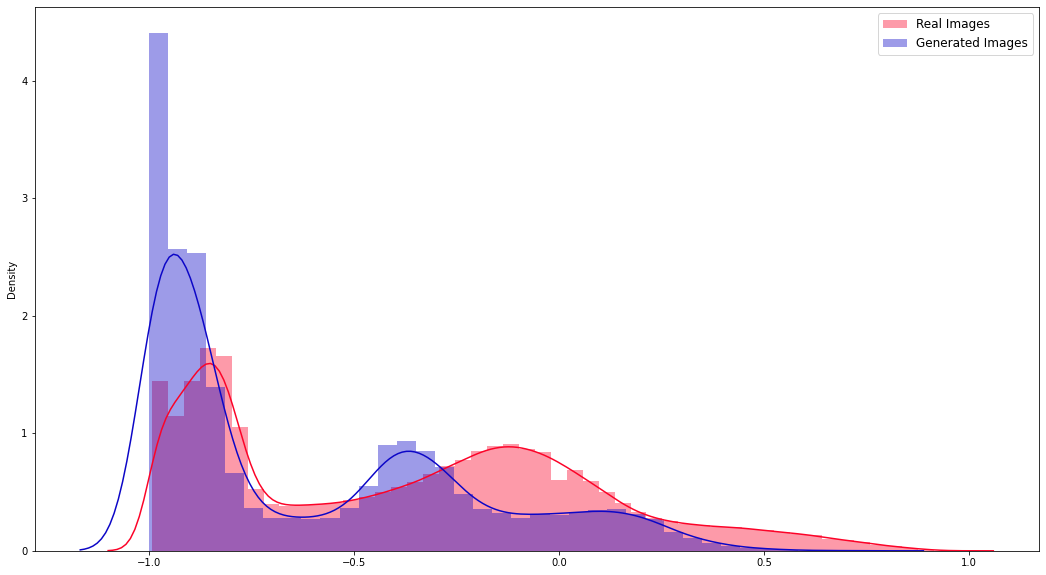

In [30]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()